In [5]:
import sys
print(sys.executable)

!{sys.executable} -m pip install pygame

c:\Users\Legion\AppData\Local\Programs\Python\Python312\python.exe
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   --- ------------------------------------ 1.0/10.6 MB 7.2 MB/s eta 0:00:02
   ---------- ----------------------------- 2.9/10.6 MB 7.6 MB/s eta 0:00:02
   --------------- ------------------------ 4.2/10.6 MB 7.0 MB/s eta 0:00:01
   ----------------------- ---------------- 6.3/10.6 MB 7.7 MB/s eta 0:00:01
   ------------------------------ --------- 8.1/10.6 MB 8.1 MB/s eta 0:00:01
   -------------------------------------- - 10.2/10.6 MB 8.4 MB/s eta 0:00:01
   ---------------------------------------- 10.6/10.6 MB 8.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import torch 
import torch.nn as nn
import pygame
import os
import random

c:\Users\Legion\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [7]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
device

device(type='cuda')

In [8]:
import os
import numpy as np
# Specify the folder path containing the .npy files
folder_path = "Quick_Draw_Data"

# List the .npy files in the folder
file_names = os.listdir(folder_path)
file_paths = [file_name for file_name in file_names if file_name.endswith('.npy')]

In [9]:
import os
import numpy as np
# Specify the folder path containing the .npy files
folder_path = "Quick_Draw_Data"

# List the .npy files in the folder
file_names = os.listdir(folder_path)
file_paths = [file_name for file_name in file_names if file_name.endswith('.npy')]

# Load the .npy files and store them in a dictionary
data_dict = {}
samples=10000
for i in range(40):
    data = np.load(folder_path + "/" + file_paths[i])[:samples]
    # label = np.empty((data.shape[0],1),dtype=object)
    # astr = file_paths[i][18:-4]
    label = np.empty((data.shape[0],1),dtype=float)
    astr=i
    for k in range(label.shape[0]):
        for j in range(label.shape[1]):
            label[k][j] = astr
    data = np.hstack((data,label))
    data_dict[i] = data


In [10]:
look_up_table={}
for i in range(40):
    look_up_table[i] = file_paths[i][18:-4]
print(look_up_table)

{0: 'airplane', 1: 'apple', 2: 'axe', 3: 'basketball', 4: 'bed', 5: 'bicycle', 6: 'bowtie', 7: 'bread', 8: 'bucket', 9: 'butterfly', 10: 'cactus', 11: 'cake', 12: 'candle', 13: 'carrot', 14: 'circle', 15: 'clock', 16: 'cloud', 17: 'crayon', 18: 'crown', 19: 'cup', 20: 'diamond', 21: 'donut', 22: 'ear', 23: 'envelope', 24: 'eye', 25: 'eyeglasses', 26: 'finger', 27: 'fish', 28: 'flower', 29: 'fork', 30: 'hammer', 31: 'hat', 32: 'headphones', 33: 'hockey stick', 34: 'ice cream', 35: 'key', 36: 'leaf', 37: 'moon', 38: 'mountain', 39: 'mushroom'}


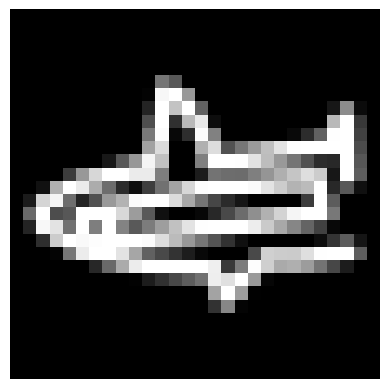

In [11]:
import matplotlib.pyplot as plt

# Specify the index of the sample you want to plot
sample_index = 0

# Access the sample from the data dictionary
sample = data_dict[0][100, :-1].astype(float)  # Exclude the label from the sample

# Reshape the sample to the image dimensions (assuming it's a 28x28 image)
image = sample.reshape((28, 28))

# Plot the image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()



In [12]:
train = []
test = []

for key, value in data_dict.items():
    # print(value[0])
    train.extend(value[:8000])  # First 8000 samples for training
    test.extend(value[8000:10000])  # Remaining 2000 samples for testing
print("Train set size:", len(train))
print("Test set size:", len(test))

Train set size: 320000
Test set size: 80000


In [13]:
num_classes = 40
learning_rate = 0.01
num_epochs = 50
batch_size= 500

In [14]:
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,shuffle=True)
test_loader= torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [23]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3,padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 40)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
# net.to(device)

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)

In [21]:
outputs = torch.tensor([])
for epoch in range(num_epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs= data[:,:784].float()
        inputs = inputs.view(-1, 1, 28, 28)  # Reshape the input tensor
        # inputs=inputs.to(device)
        labels=data[:,784]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    # print statistics at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.3f}')

print('Finished Training')

Epoch [1/50], Loss: 4.806
Epoch [2/50], Loss: 4.806
Epoch [3/50], Loss: 4.806
Epoch [4/50], Loss: 4.806
Epoch [5/50], Loss: 4.806
Epoch [6/50], Loss: 4.806


KeyboardInterrupt: 

In [19]:
PATH = './quick_draw_cnn.pth'
torch.save(net.state_dict(), PATH)

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    net.eval()
    for data in test_loader:
        inputs= data[:,:784].float()
        inputs = inputs.view(-1, 1, 28, 28)  # Reshape the input tensor
        # inputs=inputs.to(device)
        labels=data[:,784]
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test)} test images: {100 * correct / total} %')


Accuracy of the network on the 80000 test images: 85.4925 %


In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in look_up_table.values()}
total_pred = {classname: 0 for classname in look_up_table.values()}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        inputs= data[:,:784].float()
        inputs = inputs.view(-1, 1, 28, 28)  # Reshape the input tensor
        # inputs=inputs.to(device)
        labels=data[:,784]    
        outputs = net(inputs)   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            # if label.item() == 0:
                # print("predicted: ", prediction.item())
            if label == prediction:
                correct_pred[look_up_table[label.item()]] += 1
            total_pred[look_up_table[label.item()]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    total_count = total_pred[classname]
    if total_count == 0:
        accuracy = 0.0  # If no instances of this class in test dataset, set accuracy to 0
    else:
        accuracy = 100 * float(correct_count) / total_count
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: airplane is 88.5 %
Accuracy for class: apple is 92.8 %
Accuracy for class: axe   is 76.5 %
Accuracy for class: basketball is 82.8 %
Accuracy for class: bed   is 86.8 %
Accuracy for class: bicycle is 92.6 %
Accuracy for class: bowtie is 85.8 %
Accuracy for class: bread is 72.7 %
Accuracy for class: bucket is 88.0 %
Accuracy for class: butterfly is 88.4 %
Accuracy for class: cactus is 84.5 %
Accuracy for class: cake  is 88.8 %
Accuracy for class: candle is 86.0 %
Accuracy for class: carrot is 85.4 %
Accuracy for class: circle is 90.0 %
Accuracy for class: clock is 92.3 %
Accuracy for class: cloud is 83.5 %
Accuracy for class: crayon is 76.7 %
Accuracy for class: crown is 89.8 %
Accuracy for class: cup   is 82.1 %
Accuracy for class: diamond is 84.8 %
Accuracy for class: donut is 91.8 %
Accuracy for class: ear   is 81.7 %
Accuracy for class: envelope is 95.0 %
Accuracy for class: eye   is 89.4 %
Accuracy for class: eyeglasses is 86.2 %
Accuracy for class: finger is 77.

In [24]:
net = Net()
net.load_state_dict(torch.load('./quick_draw_cnn.pth'))

C:\Users\Legion\AppData\Local\Temp\ipykernel_10880\3194795397.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('./quick_draw_cnn.pth'))


<All keys matched successfully>

In [28]:
# Initialize PyGame
pygame.init()

# Set up the drawing window
canvas_width, canvas_height = 600, 600
canvas = pygame.display.set_mode((canvas_width, canvas_height))

random_number = random.randint(0, 39)

pygame.display.set_caption(f"Draw {look_up_table[random_number]} | Press ctrl+c to clear canvas & close to save")

# Colors
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)

# Function to clear the canvas
def clear_canvas():
    canvas.fill(WHITE)
    pygame.display.flip()  # Update the display to show the cleared canvas

# Game loop
drawing = False
last_pos = (0, 0)
canvas.fill(WHITE)

running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        elif event.type == pygame.MOUSEBUTTONDOWN:
            drawing = True
            last_pos = event.pos

        elif event.type == pygame.MOUSEBUTTONUP:
            drawing = False

        elif event.type == pygame.MOUSEMOTION:
            if drawing:
                mouse_pos = event.pos
                pygame.draw.line(canvas, BLACK, last_pos, mouse_pos, 5)  # Draw line
                last_pos = mouse_pos

        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_c and pygame.key.get_mods() & pygame.KMOD_CTRL:
                clear_canvas()

    pygame.display.flip()

# Save the canvas as an image
image_path = "drawn_image.jpg"
pygame.image.save(canvas, image_path)

# Clean up
pygame.quit()

print(f"Image saved at: {os.path.abspath(image_path)}")


Image saved at: c:\Users\Legion\Desktop\IIT_Bombay\Academics\Projects\Skribble_Buddy\drawn_image.jpg


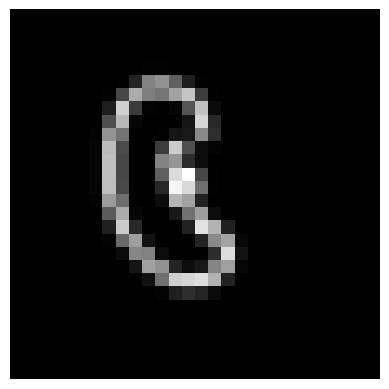

In [29]:
from PIL import Image
from skimage.transform import resize
import numpy as np

# Load the image
image = Image.open(image_path)
#Convert to grayscale
gray_image = image.convert('L')
# print(np.min(gray_image))

# Resize the image to 28x28 using skimage
resized_image = resize(np.array(gray_image), (28, 28), anti_aliasing=True)

# Convert the image to a numpy array and normalize pixel values

bitmap = (np.ones(resized_image.shape)-np.array(resized_image))
max_val = np.max(bitmap)
if max_val != 0:
    bitmap = bitmap*255/max_val

import matplotlib.pyplot as plt

# Plot the numpy array as an image

plt.imshow(bitmap, cmap='gray')  # cmap='gray' for grayscale images

plt.axis('off')  # Turn off axis
plt.show()

In [30]:
bitmap_tensor = torch.Tensor(bitmap).float()  # Convert to float tensor
bitmap_input = bitmap_tensor.view(-1, 1, 28, 28)   # Flatten to 1D tensor

# Pass the tensor to the network
outputs = net(bitmap_input)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', look_up_table[predicted.item()])


Predicted:  ear


In [34]:
import pygame
import torch
import numpy as np
from PIL import Image
from skimage.transform import resize
import random

pygame.init()

# Set up the drawing window
canvas_width, canvas_height = 600, 600
canvas = pygame.display.set_mode((canvas_width, canvas_height))

random_number = random.randint(0, 39)
pygame.display.set_caption(f"Draw {look_up_table[random_number]} | Press Ctrl+C to clear")

BLACK = (0, 0, 0)
WHITE = (255, 255, 255)

def clear_canvas():
    canvas.fill(WHITE)
    pygame.display.flip()

canvas.fill(WHITE)
drawing = False
last_pos = (0, 0)
running = True

font = pygame.font.SysFont("Arial", 28)

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            drawing = True
            last_pos = event.pos
        elif event.type == pygame.MOUSEBUTTONUP:
            drawing = False
        elif event.type == pygame.MOUSEMOTION:
            if drawing:
                mouse_pos = event.pos
                pygame.draw.line(canvas, BLACK, last_pos, mouse_pos, 5)
                last_pos = mouse_pos
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_c and pygame.key.get_mods() & pygame.KMOD_CTRL:
                clear_canvas()

    # ===== Real-time prediction section =====
    # Get current canvas pixels
    canvas_str = pygame.image.tostring(canvas, "RGB")
    img_pil = Image.frombytes("RGB", (canvas_width, canvas_height), canvas_str)
    gray_image = img_pil.convert("L")
    
    # Resize to 28x28 for the model
    resized_image = resize(np.array(gray_image), (28, 28), anti_aliasing=True)
    bitmap = (np.ones(resized_image.shape) - np.array(resized_image))
    max_val = np.max(bitmap)
    if max_val != 0:
        bitmap = bitmap * 255 / max_val
    
    # Convert to tensor and predict
    bitmap_tensor = torch.Tensor(bitmap).unsqueeze(0).unsqueeze(0)  # [1, 1, 28, 28]
    with torch.no_grad():
        outputs = net(bitmap_tensor.float())
        _, predicted = torch.max(outputs, 1)
    prediction_text = look_up_table[predicted.item()]
    
    # ===== Clear top bar and display prediction =====
    pygame.draw.rect(canvas, WHITE, (0, 0, canvas_width, 40))  # Clear area for text
    text_surface = font.render(f"Prediction: {prediction_text}", True, (255, 0, 0))
    canvas.blit(text_surface, (10, 10))
    
    pygame.display.flip()

pygame.quit()
